### Fern Ensemble Analysis.

Here we look at the most recent fern ensemble outputs with 'low_dim' i.e. UMAP n_components <= 40.

We also move to using Spectral Clustering for the concensus function, since HC tended to give very uneven clusters (hierarchical constraint not valid?)

In [54]:
import matplotlib.pyplot as plt
import pickle as pk
import pandas as pd
import numpy as np
import wandb
import umap
import seaborn as sns
import colorcet as cc
from itertools import combinations
import networkx as nx
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from matplotlib.colors import ListedColormap
from sklearn.cluster import SpectralClustering

from utilities import run_configs, load_symptom_data, modularity, clustering_similarity

%matplotlib inline

In [55]:
LINKAGE_METHOD = 'average'
IGNORE_LABEL = None
SEED = 42

In [56]:
# with open('./fern_ensemble_outputs/both_CAS_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs_cas = pk.load(infile)
# with open('./fern_ensemble_outputs/kmeans_CAS_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs_cas = pk.load(infile)
    
# with open('./fern_ensemble_outputs/both_JC_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs_cas = pk.load(infile)
    
# with open('./fern_ensemble_outputs/kmeans_JC_50_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs_cas = pk.load(infile)
    
with open('./fern_ensemble_outputs_spectral/run_19_kmeans_JC_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
    ensemble_outputs_cas = pk.load(infile)

In [57]:
# with open('./fern_ensemble_outputs/kmeans_JC_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)
    
# with open('./fern_ensemble_outputs/kmeans_JC_50_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)


# with open('./fern_ensemble_outputs/kmeans_JC_20_0.0/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)

# with open('./fern_ensemble_outputs/both_JC_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)
# with open('./fern_ensemble_outputs/hdbscan_CAS_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)
# with open('./fern_ensemble_outputs/kmeans_JC_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)

with open('./fern_ensemble_outputs_spectral/run_1_kmeans_JC_50_0.5/ensemble_outputs.pickle', 'rb') as infile:
    ensemble_outputs = pk.load(infile)

In [64]:
assert (ensemble_outputs[0]['final_clusters'][7] == final_clusters.cluster).all()

In [163]:
ensemble_outputs[0]['library'].iloc[0]['current_params']

{'kmeans__init': 'random',
 'kmeans__n_clusters': 6,
 'kmeans__n_init': 6,
 'umap__metric': 'manhattan',
 'umap__min_dist': 0.5145245300932275,
 'umap__n_components': 31,
 'umap__n_neighbors': 87}

In [155]:
all_ami = []
all_n_clusters = []
all_n_components = []

for ri, row in ensemble_outputs[0]['library'].iterrows():

    labels = row.labels
    all_ami.append(adjusted_mutual_info_score(final_clusters.cluster, labels))
    
    params = row.current_params
    all_n_clusters.append(params['kmeans__n_clusters'])
    all_n_components.append(params['umap__n_components'])
    

In [114]:
worst_in_library = np.argmin(all_ami)
best_in_library = np.argmax(all_ami)

In [127]:
with open('./figs/embedding_tsne_sil_mean.pickle', 'rb') as infile:
    tsne_embedding = pk.load(infile)

/tmp/ipykernel_18147/394165847.py:39: UserWarning: The palette list has more values (14) than needed (9), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_18147/394165847.py:39: UserWarning: 
The palette list has fewer values (14) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_18147/394165847.py:39: UserWarning: The palette list has more values (14) than needed (10), which may not be intended.
  sns.scatterplot(


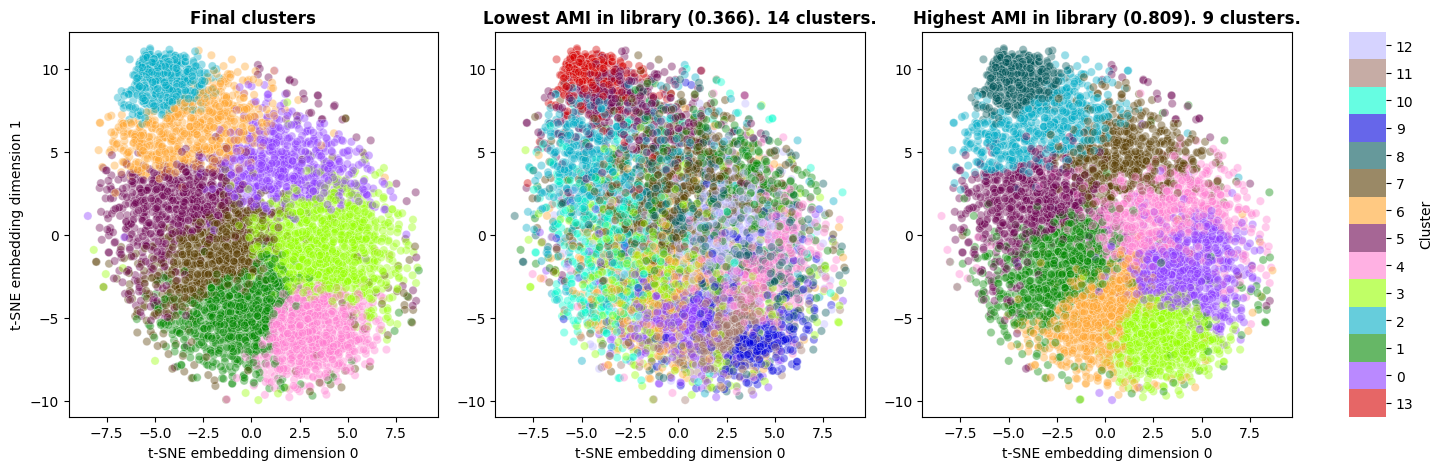

In [142]:
max_cluster_count = 14  # including -1 for noise
embedding_algo = 't-SNE'
alpha = 0.4 # for scatter plots

fig, ax = plt.subplots(1, 4, figsize=(17, 5), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})

norm = plt.Normalize(0, max_cluster_count, )
palette = sns.color_palette(cc.glasbey, n_colors=max_cluster_count)
cmap = ListedColormap(palette.as_hex())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cluster_lists = [
    [i for i in final_clusters.cluster] + [-1],
    [i for i in ensemble_outputs[0]['library'].iloc[worst_in_library].labels] + [-1],
    [i for i in ensemble_outputs[0]['library'].iloc[best_in_library].labels] + [-1]
]
cluster_counts = [
    None,
    len(np.unique(ensemble_outputs[0]['library'].iloc[worst_in_library].labels)),
    len(np.unique(ensemble_outputs[0]['library'].iloc[best_in_library].labels))
]
labels = ['A', 'B', 'C']
titles = [
    'Final clusters',
    'Lowest AMI in library (%.3f). %d clusters.' % (np.min(all_ami), cluster_counts[1]),
    'Highest AMI in library (%.3f). %d clusters.' % (np.max(all_ami), cluster_counts[2]),
]
em = tsne_embedding

xmin = em[:,0].min()
xmax = em[:,0].max()
ymin = em[:,1].min()
ymax = em[:,1].max()
embedding = np.append(em, [[xmin-10, ymin-10]], axis=0)

for i in range(3):
    
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        palette = palette,
        hue=cluster_lists[i],
        data=em,
        legend=None,
        ax=ax[i],
        alpha=alpha
        
    )
    ax[i].set_xlabel('%s embedding dimension 0' % embedding_algo)


ax[0].set_ylabel('%s embedding dimension 1' % embedding_algo)
cbar = fig.colorbar(sm, cax=ax[3], orientation="vertical", alpha=alpha*1.5, label='Cluster')
offset = ax[3].get_ylim()[1] / (2 * max_cluster_count)
cbar.set_ticks(np.arange(0, max_cluster_count) + offset, labels=[str(l) if l != -1 else '13' for l in range(-1,13)])
ax[3].set_frame_on(False)

axlim_offset = 1
for i in range(3):
    ax[i].set_xlim([xmin - axlim_offset, xmax + axlim_offset])
    ax[i].set_ylim([ymin - axlim_offset, ymax + axlim_offset])
    ax[i].set_title(titles[i], fontweight='bold')

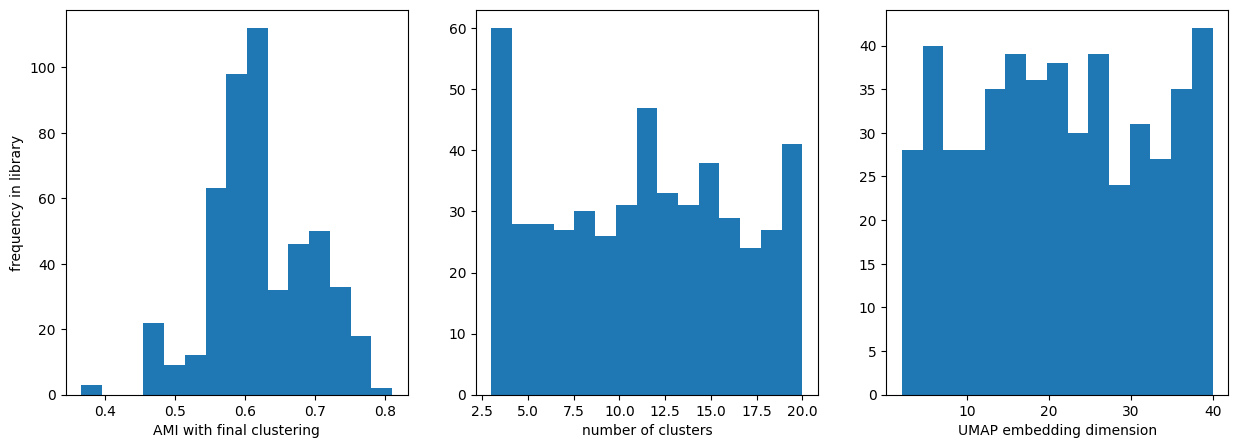

In [161]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(all_ami, orientation="vertical", bins=15)
plt.xlabel('AMI with final clustering')
plt.ylabel('frequency in library')
plt.subplot(1,3,2)
plt.hist(all_n_clusters, orientation="vertical", bins=15)
plt.xlabel('number of clusters')
plt.subplot(1,3,3)
plt.hist(all_n_components, orientation="vertical", bins=15)
plt.xlabel('UMAP embedding dimension');

In [164]:
np.mean(all_ami)

0.6218406258770417

In [5]:
for i in range(15):
    nc = i + 1
    print(
        nc, 
        adjusted_mutual_info_score(
            ensemble_outputs[0]['final_clusters'][i], ensemble_outputs_cas[0]['final_clusters'][i]
        )
    )

1 1.0
2 0.8151506380463551
3 0.5015155973876537
4 0.5479040329992246
5 0.5598250325490842
6 0.6366855442465852
7 0.7391487547129576
8 0.6904338420952291
9 0.6982225177760256
10 0.6799267019830983
11 0.6624739689945494
12 0.662446791246078
13 0.6546009451178918
14 0.634843583054393
15 0.6264605142950479


In [6]:
all_data = pd.read_csv(run_configs[1]['data_path'], index_col=0)
all_data.loc[all_data.Physical_PEM_Severity==0, 'Physical_PEM_Severity'] = np.nan
all_data.loc[all_data.Cognitive_PEM_Severity==0, 'Cognitive_PEM_Severity'] = np.nan

In [7]:
symptom_data = load_symptom_data(run_configs[1]['data_path'])

In [8]:
def ensemble_to_co_association(ensemble):
    if isinstance(ensemble, pd.DataFrame) and 'labels' in ensemble.columns:
        df = pd.DataFrame(ensemble.labels)
        df = pd.DataFrame(df['labels'].to_list()).transpose()
    else:
        df = pd.DataFrame(ensemble).transpose()

    N = len(df)

    co_association_matrix = np.zeros([N, N])
    n_estimators = len(ensemble)

    for ri, row in df.iterrows():

        if ri%500 == 0:
            print(ri)

        compare = df.loc[ri + 1:]
        if IGNORE_LABEL is not None:
            shared_counts = ((row == compare) * (row != -1) * (compare != -1)).sum(axis=1)
        else:
            shared_counts = (row == compare).sum(axis=1)

        co_association_matrix[ri, ri + 1:] = shared_counts / n_estimators

    return co_association_matrix



In [9]:
# ensemble = ensemble_outputs[0]['library'].iloc[ensemble_outputs_cas[0]['ensemble_indices']]

In [10]:
# final_co_association_matrix = ensemble_to_co_association(ensemble)

In [11]:
# sc = SpectralClustering(6, affinity='precomputed', n_init=100)
# sc.fit(final_co_association_matrix)        

In [49]:
def convert_age(age_string):
    conversion_diict = {
        '30-39': 35,
        '40-49': 45,
        '50-59': 55,
        '18-29': 24,
        '60-69': 65,
        '70-79': 75,
        '80+': 80
    }
    return conversion_diict[age_string]


def build_cluster_summary(data, labels):

    _all_data= data.copy()
    symptoms = [
        col
        for col in _all_data.columns
        if 'Symptom' in col
    ]

    _all_data['cluster'] = labels
    _all_data['dummy'] = 1
    _all_data['woman'] = _all_data['Demographics_Gender_Cleaned'] == 'Woman'
    _all_data['Flag_MCAS_norm'] = _all_data['Flag_MCAS'] / 6
    _all_data['symptom_count'] = _all_data[symptoms].sum(axis=1)
    _all_data['age_numeric'] = _all_data['Demographics_Age_Cleaned'].apply(convert_age)
    _all_data['Physical_PEM_Severity_norm'] = _all_data['Physical_PEM_Severity'] / 10
    _all_data['Cognitive_PEM_Severity_norm'] = _all_data['Cognitive_PEM_Severity'] / 10

    cluster_summary = _all_data.groupby('cluster').agg({
        'dummy': len,
        'Flag_MECFS': sum,
        'Flag_POTS': pd.Series.mode,
        'Flag_MCAS_norm': sum,
        'woman': sum,
        'symptom_count': np.median,
        'age_numeric': np.mean,
        'Physical_PEM_Severity_norm': np.nanmean,
        'Cognitive_PEM_Severity_norm': np.nanmean
    })
    cluster_summary['Flag_MECFS'] /= cluster_summary['dummy']
    cluster_summary['Flag_MCAS_norm'] /= cluster_summary['dummy']
    cluster_summary['woman'] /= cluster_summary['dummy']
    cluster_summary.rename(columns={'dummy': 'size'}, inplace=True)

    return cluster_summary

In [50]:
# final_clusters = sc.labels_
# final_clusters = ensemble_outputs_cas[1]['final_clusters'][7]
# final_clusters = ensemble_outputs[0]['final_clusters'][5]
# final_clusters = pd.read_csv('../clusterings/chris/parametric_umap_n_clusters_7.csv', index_col=0)


#final_clusters = pd.read_csv('../clusterings/chris/umap_kmeans_ensemble_up_to_40_components_inclusion_any_n_cluster_8.csv', index_col=0)
final_clusters = pd.read_csv('../clusterings/chris/lowdim_spectral_ensemble_50_kmeans_joint_criterion_alpha_0.5_n_clusters_8.csv', index_col=0)

In [51]:
vals = np.unique(final_clusters, return_counts=True)
vals

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 615,  872,  506, 1105,  887,  727,  611,  708]))

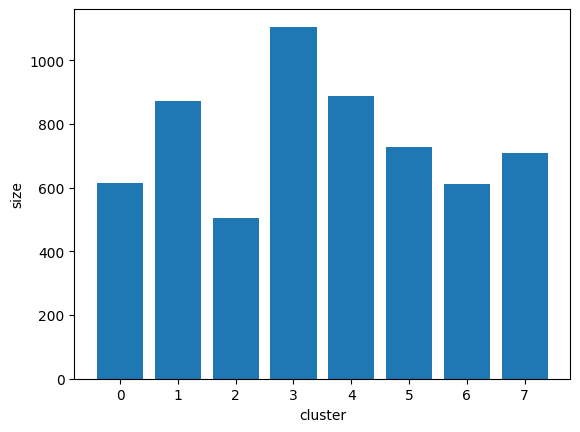

In [52]:
plt.bar(vals[0], vals[1])
plt.xlabel('cluster')
plt.ylabel('size');

In [16]:
# final_clusters

In [17]:
fc = pd.DataFrame(index=symptom_data.index)
fc['cluster'] = final_clusters

In [18]:
# fc.to_csv('../clusterings/chris/lowdim_spectral_ensemble_50_kmeans_joint_criterion_alpha_0.5_n_clusters_6.csv')

In [53]:
build_cluster_summary(all_data, final_clusters)

,size,Flag_MECFS,Flag_POTS,Flag_MCAS_norm,woman,symptom_count,age_numeric,Physical_PEM_Severity_norm,Cognitive_PEM_Severity_norm
cluster,,,,,,,,,
0,615,0.596748,"Possible, had tachycardia/palpitations",0.130081,0.832520,53.0,45.087805,0.806937,0.738581
1,872,0.308486,"No, no tachycardia",0.101491,0.747706,30.0,47.630734,0.740079,0.478479
2,506,0.361660,"Possible, had tachycardia/palpitations",0.365613,0.865613,89.0,45.535573,0.875547,0.785714
3,1105,0.578281,"No, no tachycardia",0.091101,0.693213,34.0,47.300452,0.748592,0.654334
4,887,0.178129,"No, no tachycardia",0.068207,0.692221,21.0,50.280722,0.675869,0.478670
5,727,0.650619,"Possible, had tachycardia/palpitations",0.154287,0.833563,54.0,45.005502,0.793506,0.610575
6,611,0.553191,"Possible, had tachycardia/palpitations",0.229405,0.855974,69.0,45.664484,0.848414,0.736286
7,708,0.548023,"No, no tachycardia",0.095574,0.836158,40.0,47.194915,0.762693,0.554049


In [20]:
baseline_frequencies = {
    col: all_data[col].sum() / len(all_data)
    for col in all_data.columns
    if 'Symptom' in col
}

In [21]:
baseline_df = pd.DataFrame(index=baseline_frequencies.keys())
baseline_df['population'] = baseline_frequencies.values()
baseline_df.sort_values('population', ascending=False, inplace=True)

In [22]:
baseline_df

,population
Symptom_Fatigue,0.979440
Symptom_Memory_short,0.924225
Symptom_PEM,0.883601
Symptom_Cognitive_Functioning_attentionconcentration,0.752943
Symptom_Shortness_of_breath,0.736860
...,...
Symptom_SkinAllergy_shingles,0.025701
Symptom_Hallucinations_other,0.023379
Symptom_Reproductive_postmenopausal_bleeding,0.016084
Symptom_Reproductive_early_menopause,0.013928


In [23]:
def build_cluster_symptoms(data, labels, baseline_df):

    _all_data= data.copy()
#     symptoms = [
#         col
#         for col in _all_data.columns
#         if 'Symptom' in col
#     ]
    symptoms= list(baseline_df.index)
    _all_data['cluster'] = labels
    count = _all_data.groupby('cluster').sum()[symptoms]
    size = _all_data.groupby('cluster').agg({'Symptom_Memory_short': 'count'}).rename(columns={'Symptom_Memory_short': 'size'})
    
    for col in count.columns:
        count[col] = count[col] / size['size']

    delta = count.copy().transpose()
    for col in delta.columns:
        delta[col] -= baseline_df.population
        
    cluster_symptoms = {}
    more_common_symptoms = {}
    less_common_symptoms = {}
    full_symptoms_by_cluster = baseline_df.copy()
    
    for c in np.unique(labels):
        cluster_symptoms[c] = pd.DataFrame({
            'diff': delta[c],
            'abs': count.transpose()[c]
        })#.sort_values('diff', ascending=False)
        cluster_symptoms[c]['diff (abs)'] = [
            ('%.3f (%.3f)' % (row['diff'], row['abs'])) for i, row in cluster_symptoms[c].iterrows()
        ]
        
#         full_symptoms_by_cluster[c] = [
#             ('%.3f (%.3f)' % (row['diff'], row['abs'])) for i, row in cluster_symptoms[c].iterrows()
#         ]
        full_symptoms_by_cluster['%d delta' % c] = [
            ('%.3f' % row['diff']) for i, row in cluster_symptoms[c].iterrows()
        ]
        full_symptoms_by_cluster['%d freq' % c] = [
            ('%.3f' % row['abs']) for i, row in cluster_symptoms[c].iterrows()
        ]
        
        more_common_symptoms[c] = cluster_symptoms[c][cluster_symptoms[c]['diff'] > 0].iloc[0:10]
        less_common_symptoms[c] = cluster_symptoms[c][cluster_symptoms[c]['diff'] < 0].iloc[-20:]
        
    return cluster_symptoms, more_common_symptoms, less_common_symptoms, full_symptoms_by_cluster

In [24]:
cluster_symptoms, more_common_symptoms, less_common_symptoms, full_symptoms_by_cluster  = build_cluster_symptoms(all_data, final_clusters, baseline_df)
# cluster_symptoms = build_cluster_symptoms(all_data, list(tessa.cluster), baseline_df)

In [25]:
symptom_names = [i.replace('Symptom_', '') for i in full_symptoms_by_cluster.index]

In [26]:
full_symptoms_by_cluster.population = full_symptoms_by_cluster.population.round(3)
full_symptoms_by_cluster.set_index(keys=pd.Index(symptom_names), inplace=True)

In [27]:
full_symptoms_by_cluster.to_csv('../clusterings/chris/full_symptom_table.csv')

In [28]:
sleep_symptoms = [
    s for s in full_symptoms_by_cluster.index if 'sleep' in s.lower()
]

In [29]:
sleep_symptoms += ['Waking_up_in_night', 'Insomnia']

In [30]:
full_symptoms_by_cluster.loc[sleep_symptoms]

,population,0 delta,0 freq,1 delta,1 freq,2 delta,2 freq,3 delta,3 freq,4 delta,4 freq,5 delta,5 freq,6 delta,6 freq,7 delta,7 freq
Sleep_other,0.528,0.135,0.663,-0.157,0.372,0.286,0.814,-0.074,0.454,-0.244,0.284,0.126,0.655,0.197,0.725,-0.006,0.523
Difficulty_falling_asleep,0.406,0.128,0.533,-0.133,0.273,0.324,0.729,-0.101,0.305,-0.233,0.172,0.120,0.525,0.216,0.622,-0.040,0.366
Sleep_apnea,0.126,0.007,0.133,-0.047,0.079,0.176,0.302,-0.044,0.082,-0.066,0.060,0.011,0.138,0.093,0.219,-0.015,0.112
Waking_up_in_night,0.483,0.118,0.602,-0.144,0.339,0.293,0.777,-0.102,0.381,-0.263,0.220,0.160,0.644,0.214,0.697,0.005,0.489
Insomnia,0.693,0.084,0.777,-0.120,0.573,0.269,0.962,-0.087,0.606,-0.298,0.396,0.193,0.886,0.210,0.903,0.012,0.705


In [31]:
for c in np.unique(final_clusters):
    print(
        c, 
        [s.replace('Symptom_', '') for s in list(more_common_symptoms[c].index)]
    )

0 ['Fatigue', 'Memory_short', 'PEM', 'Cognitive_Functioning_attentionconcentration', 'Shortness_of_breath', 'Insomnia', 'Tightness_of_chest', 'Muscle_aches', 'Dizziness_vertigo', 'Cognitive_Functioning_thinking']
1 ['Memory_short', 'Shortness_of_breath', 'Tightness_of_chest', 'Heart_palpitations', 'Gasping_air_normal_oxygen', 'Pain_burning_chest', 'Respiratory_other']
2 ['Fatigue', 'Memory_short', 'PEM', 'Cognitive_Functioning_attentionconcentration', 'Shortness_of_breath', 'Insomnia', 'Tightness_of_chest', 'Muscle_aches', 'Dizziness_vertigo', 'Cognitive_Functioning_thinking']
3 ['Fatigue', 'PEM', 'Cognitive_Functioning_attentionconcentration', 'Cognitive_Functioning_thinking', 'Cognitive_Functioning_executive', 'Cognitive_Functioning_problemsolving', 'Speech_difficulty_finding_words', 'Cognitive_Functioning_slowedthoughts', 'Memory_long', 'Speech_difficulty_communicating_verbally']
4 ['Loss_of_smell', 'Loss_of_taste', 'Altered_smell', 'Respiratory_other']
5 ['Fatigue', 'PEM', 'Cogniti

In [32]:
for c in np.unique(final_clusters):
    print(c)
    for lcs in list(less_common_symptoms[c].index):
        print(lcs.replace('Symptom_', ''))

0
Hearing_loss
Reproductive_other_menstrual_issues
Respiratory_other
Eye_Vision_redness_outside_eye
Dermatographia
Sensations_facial_pressure_left
Hallucinations_auditory
Sensations_facial_pressure_right
Sensations_facial_pressure_other
SkinAllergy_other_itchy
Inability_to_yawn
Ear_numbness
Coughing_up_blood
New_anaphylaxis
Reproductive_testicle_penis_pain_changes
Hallucinations_tactile
Sensations_facial_paralysis
SkinAllergy_shingles
Hallucinations_other
Reproductive_postmenopausal_bleeding
1
Hallucinations_auditory
Sensations_facial_pressure_right
Sensations_facial_pressure_other
SkinAllergy_other_itchy
Speech_changes_to_secondary_languages
Inability_to_yawn
Ear_numbness
Coughing_up_blood
Speech_other
New_anaphylaxis
Eye_Vision_tunnel_vision
Reproductive_testicle_penis_pain_changes
Hallucinations_tactile
Sensations_facial_paralysis
Heightened_taste
SkinAllergy_shingles
Hallucinations_other
Reproductive_postmenopausal_bleeding
Reproductive_early_menopause
Eye_Vision_loss_of_vision
2
3

In [33]:
symptom_data

,Symptom_Memory_short,Symptom_Memory_long,Symptom_Memory_no_new_memories,Symptom_Memory_forget_tasks,Symptom_Memory_other,Symptom_Cognitive_Functioning_thinking,Symptom_Cognitive_Functioning_executive,Symptom_Cognitive_Functioning_problemsolving,Symptom_Cognitive_Functioning_slowedthoughts,Symptom_Cognitive_Functioning_fastthoughts,...,Symptom_SkinAllergy_itchy_skin,Symptom_SkinAllergy_itchy_eyes,Symptom_SkinAllergy_heighted_reaction_allergies,Symptom_SkinAllergy_brittle_nail,Symptom_SkinAllergy_other_itchy,Symptom_SkinAllergy_shingles,Symptom_PEM,Symptom_Fatigue,Symptom_Change_sensitivity_to_meds,Symptom_New_allergies
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,1
5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,1,0,0,1,1,0,0
6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
8,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14158,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1,1,0,1,0,0,1,1,1,0
14161,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1,0,0,0,0,0,1,1,0,0
14163,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,1,1,0
14166,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
all_data['c'] = final_clusters.cluster

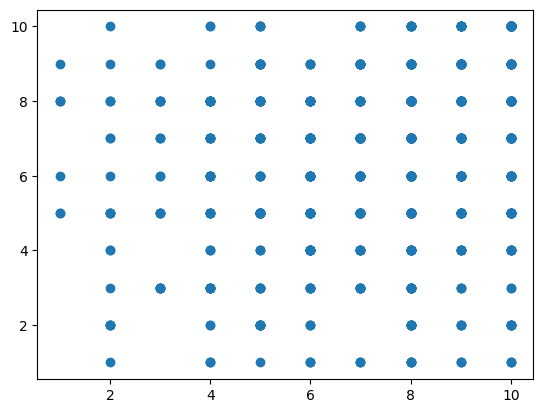

In [35]:
data = all_data[all_data.c==3]
plt.scatter(data['Physical_PEM_Severity'], data['Cognitive_PEM_Severity'] )

In [43]:
1 - (all_data['Cognitive_PEM_Severity'] > all_data['Physical_PEM_Severity']).sum() / len(all_data)

0.8870834024208257

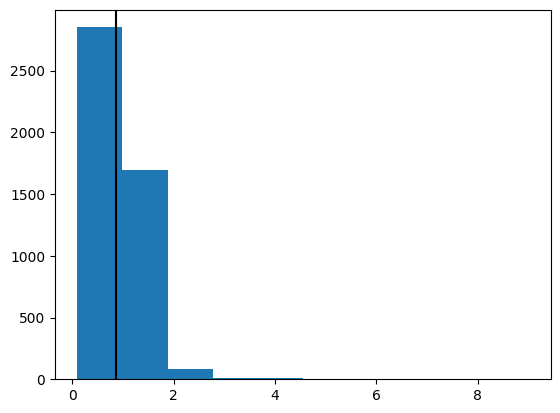

In [39]:
plt.hist(all_data['Cognitive_PEM_Severity'] / all_data['Physical_PEM_Severity'])
plt.axvline(np.mean(all_data['Cognitive_PEM_Severity'] / all_data['Physical_PEM_Severity']), c='k')

(array([196., 216., 298., 346., 603., 565., 724., 772., 479., 520.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

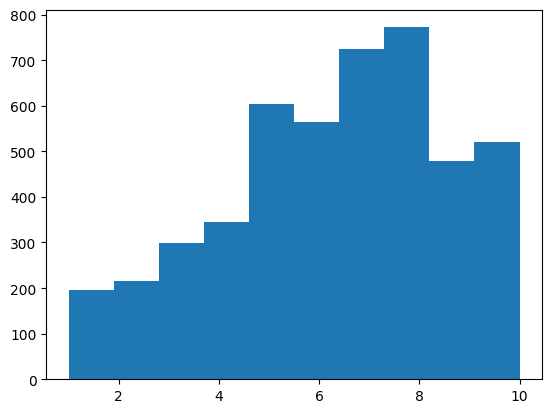

In [41]:
plt.hist(all_data['Cognitive_PEM_Severity'])# / all_data['Physical_PEM_Severity'])

(array([  24.,   58.,  108.,  204.,  415.,  404.,  691., 1167.,  930.,
        1270.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

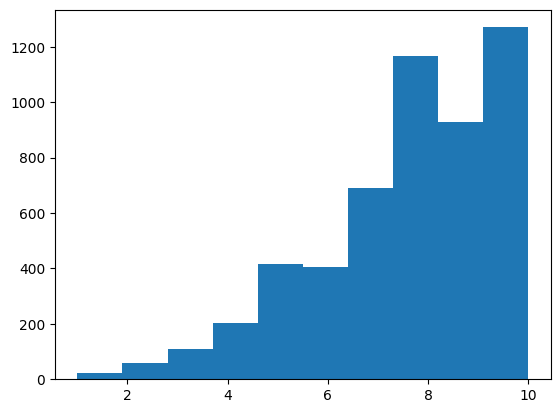

In [42]:
plt.hist(all_data['Physical_PEM_Severity'])

In [40]:
np.mean(all_data['Cognitive_PEM_Severity'] / all_data['Physical_PEM_Severity'])

0.8607770944459743

In [45]:
np.mean(all_data['Cognitive_PEM_Severity']) / 10

0.6371265098537826

In [46]:
np.mean(all_data['Physical_PEM_Severity']) / 10

0.7782583949914627

In [47]:
np.std(all_data['Physical_PEM_Severity']) / 10

0.19974771228023597

In [48]:
np.std(all_data['Cognitive_PEM_Severity']) / 10

0.24711749355438445

0.1983739837398374
0.04357798165137615
0.15019762845849802
0.17647058823529413
0.043968432919954906
0.0921595598349381
0.13911620294599017
0.08333333333333333


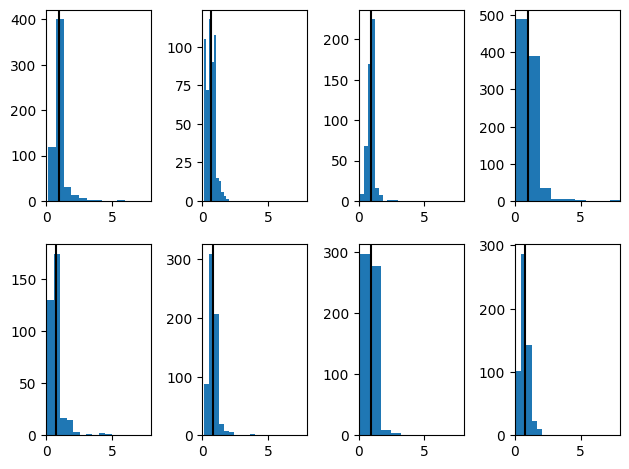

In [37]:

for i in range(8):
    data = all_data[all_data.c==i]
    plt.subplot(2,4,i+1)
    plt.hist(data['Cognitive_PEM_Severity'] / data['Physical_PEM_Severity'])
    plt.axvline(np.mean(data['Cognitive_PEM_Severity'] / data['Physical_PEM_Severity']), c='k')
    plt.xlim([0,8])
    
    print((data['Cognitive_PEM_Severity'] > data['Physical_PEM_Severity']).sum() / len(data))
    
plt.tight_layout()

In [283]:
ensemble_outputs[0].keys()

dict_keys(['seed', 'library_clusters', 'final_clusters', 'library', 'ensemble_indices', 'ari_with_base_final', 'ami_with_base_final', 'ari_with_base_library', 'ami_with_base_library', 'ari_with_tessa', 'ami_with_tessa'])

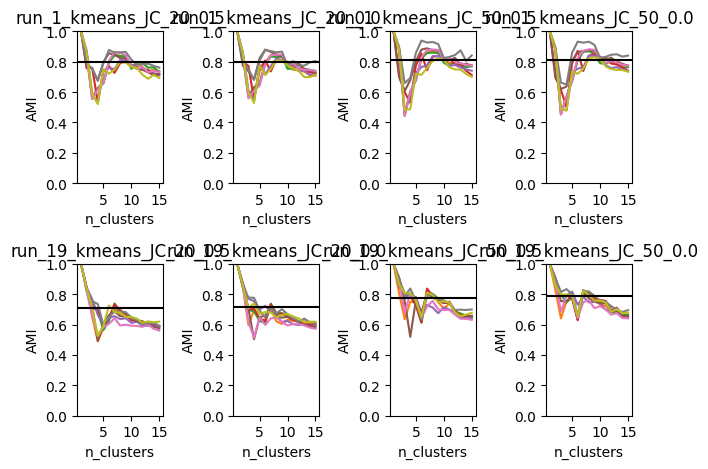

In [80]:
# E = ['kmeans_JC_50_0.5', 'kmeans_CAS_50_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 
#      'kmeans_CAS_100_0.5', 'kmeans_JC_20_0.0', 'kmeans_JC_100_0.5', 'kmeans_JC_100_0.0']

# E = ['kmeans_JC_50_0.5', 'hdbscan_JC_20_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 'hdbscan_CAS_20_0.5', 'kmeans_JC_20_0.0']

E = [
    'run_1_kmeans_JC_20_0.5', 'run_1_kmeans_JC_20_0.0', 
    'run_1_kmeans_JC_50_0.5', 'run_1_kmeans_JC_50_0.0',
    'run_19_kmeans_JC_20_0.5', 'run_19_kmeans_JC_20_0.0', 
    'run_19_kmeans_JC_50_0.5', 'run_19_kmeans_JC_50_0.0'
]

for ei, e in enumerate(E):
    with open('./fern_ensemble_outputs_spectral/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
#     with open('./fern_ensemble_outputs/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
        _ensemble_outputs = pk.load(infile)

    plt.subplot(2,4,ei+1)
    plt.title(e)
    
    M=[]
    for i in range(10):
        if len(_ensemble_outputs) > i+1:
            plt.plot(
                [i+1 for i in range(15)],
                _ensemble_outputs[i]['ami_with_base_final']
            )
            M.append(_ensemble_outputs[i]['ami_with_base_final'])
        
    plt.axhline(np.mean(M), c='k')
    plt.xlabel('n_clusters')
    plt.ylabel('AMI')
    plt.ylim([0,1])
        
plt.tight_layout()

In [81]:
# # E = ['kmeans_JC_50_0.5', 'kmeans_CAS_50_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 'kmeans_CAS_100_0.5', 'kmeans_JC_20_0.0']

# E = ['kmeans_JC_50_0.5', 'kmeans_CAS_50_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 
#      'kmeans_CAS_100_0.5', 'kmeans_JC_20_0.0', 'kmeans_JC_100_0.5', 'kmeans_JC_100_0.0']


# for ei, e in enumerate(E):
#     with open('./fern_ensemble_outputs/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
#         _ensemble_outputs = pk.load(infile)

#     plt.subplot(2,4,ei+1)
#     plt.title(e)
#     M=[]
#     for i in range(10):
#         if len(_ensemble_outputs) > i+1:
#             plt.plot(
#                 [i+1 for i in range(15)],
#                 _ensemble_outputs[i]['ari_with_base_final']
#             )
#             M.append(_ensemble_outputs[i]['ari_with_base_final'])
        
#     plt.axhline(np.mean(M), c='k')
#     plt.xlabel('n_clusters')
#     plt.ylabel('ARI')
#     plt.ylim([0,1])
        
# plt.tight_layout()

In [298]:
# E = ['both_JC_20_0.5', 'both_CAS_20_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 'hdbscan_JC_20_0.5', 'hdbscan_CAS_20_0.5']

# for ei, e in enumerate(E):
#     with open('./fern_ensemble_outputs/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
#         _ensemble_outputs = pk.load(infile)

#     plt.subplot(2,3,ei+1)
#     plt.title(e)
#     for i in range(10):
#         plt.plot(
#             [i+1 for i in range(15)],
#             _ensemble_outputs[i]['ami_with_tessa']
#         )
#         plt.axvline(6, c='k')
#         plt.xlabel('n_clusters')
#         plt.ylabel('AMI_Tessa')
#         plt.ylim([0,1])
        
# plt.tight_layout()

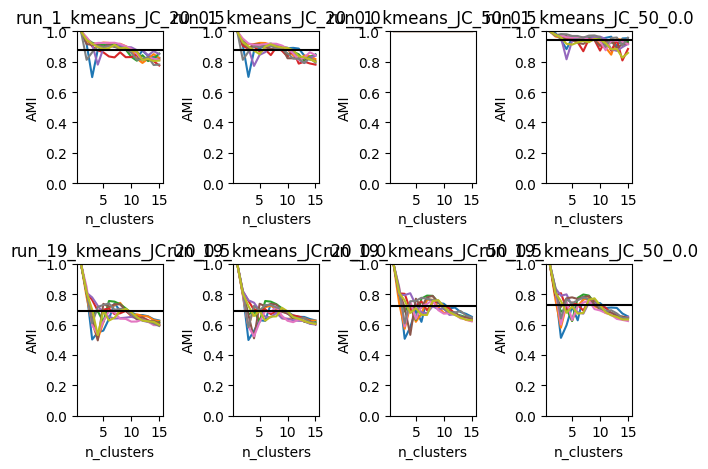

In [83]:
base_E = 'run_1_kmeans_JC_50_0.5'

E = [
    'run_1_kmeans_JC_20_0.5', 'run_1_kmeans_JC_20_0.0', 
    'run_1_kmeans_JC_50_0.5', 'run_1_kmeans_JC_50_0.0',
    'run_19_kmeans_JC_20_0.5', 'run_19_kmeans_JC_20_0.0', 
    'run_19_kmeans_JC_50_0.5', 'run_19_kmeans_JC_50_0.0'
]

with open('./fern_ensemble_outputs_spectral/%s/ensemble_outputs.pickle' % base_E, 'rb') as infile:
        _base_e = pk.load(infile)

for ei, e in enumerate(E):
    with open('./fern_ensemble_outputs_spectral/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
        _ensemble_outputs = pk.load(infile)

    plt.subplot(2,4,ei+1)
    plt.title(e)
    M=[]
    for i in range(len(_base_e)):
#     for i in range(10):
        if len(_ensemble_outputs) > i+1:
            ami = [
                adjusted_mutual_info_score(
                    _base_e[i]['final_clusters'][j],
                    _ensemble_outputs[i]['final_clusters'][j]
                )
                for j in range(15)
            ]

            plt.plot(
                [i+1 for i in range(15)],
                ami
            )
            M.append(ami)
        
    plt.axhline(np.mean(M), c='k')
    plt.xlabel('n_clusters')
    plt.ylabel('AMI')
    plt.ylim([0,1])
        
plt.tight_layout()

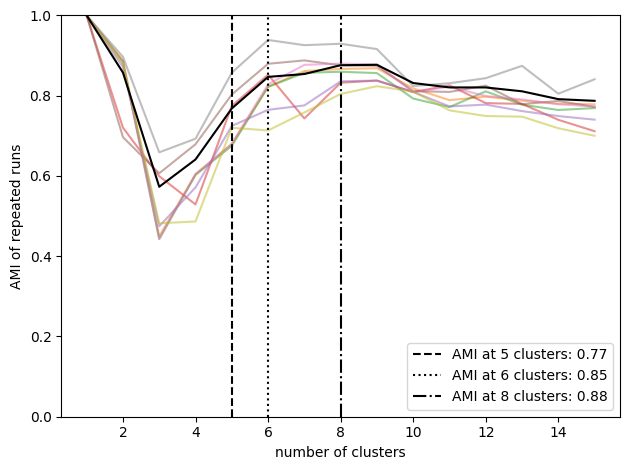

In [45]:
base_E = 'run_1_kmeans_JC_50_0.5'

E = [
    'run_1_kmeans_JC_50_0.5'
]

with open('./fern_ensemble_outputs_spectral/%s/ensemble_outputs.pickle' % base_E, 'rb') as infile:
        _base_e = pk.load(infile)

for ei, e in enumerate(E):
    with open('./fern_ensemble_outputs_spectral/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
        _ensemble_outputs = pk.load(infile)

    plt.subplot(1,1,ei+1)
#     plt.title(e)
    M=[]
    for i in range(len(_base_e)):
#     for i in range(10):
        if len(_ensemble_outputs) > i+1:
            ami = [
                adjusted_mutual_info_score(
                    _base_e[0]['final_clusters'][j],
                    _ensemble_outputs[i]['final_clusters'][j]
                )
                for j in range(15)
            ]

            plt.plot(
                [i+1 for i in range(15)],
                ami,
                alpha=0.5
            )
            M.append(ami)
        
#     plt.axhline(np.mean(M), c='k')
    plt.plot([i+1 for i in range(15)], np.array(M).mean(axis=0), c='k')
    plt.xlabel('number of clusters')
    plt.ylabel('AMI of repeated runs')
    plt.ylim([0,1])
    plt.axvline(5, linestyle='--', c='k', label='AMI at 5 clusters: %.2f' % np.array(M).mean(axis=0)[4])
    plt.axvline(6, linestyle=':', c='k', label='AMI at 6 clusters: %.2f' % np.array(M).mean(axis=0)[5])
    plt.axvline(8, linestyle='-.', c='k', label='AMI at 8 clusters: %.2f' % np.array(M).mean(axis=0)[7])
#     plt.axhline(np.array(M).mean(axis=0)[7], linestyle='--', c='k')
        
plt.legend()
plt.tight_layout()

In [82]:
# base_E = 'kmeans_JC_100_0.5'
# # base_E = 'both_JC_20_0.5'
# # E = ['kmeans_JC_50_0.5', 'kmeans_CAS_50_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 'kmeans_CAS_100_0.5', 'kmeans_JC_20_0.0']

# E = ['kmeans_JC_50_0.5', 'kmeans_CAS_50_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 
#      'kmeans_CAS_100_0.5', 'kmeans_JC_20_0.0', 'kmeans_JC_100_0.5', 'kmeans_JC_100_0.0']


# with open('./fern_ensemble_outputs/%s/ensemble_outputs.pickle' % base_E, 'rb') as infile:
#         _base_e = pk.load(infile)

# for ei, e in enumerate(E):
#     with open('./fern_ensemble_outputs/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
#         _ensemble_outputs = pk.load(infile)

#     plt.subplot(2,4,ei+1)
#     plt.title(e)
#     M=[]
#     for i in range(len(_base_e)):
# #     for i in range(10):
#         if len(_ensemble_outputs) > i+1:
#             ami = [
#                 adjusted_mutual_info_score(
#                     _base_e[i]['final_clusters'][j],
#                     _ensemble_outputs[i]['final_clusters'][j]
#                 )
#                 for j in range(15)
#             ]

#             plt.plot(
#                 [i+1 for i in range(15)],
#                 ami
#             )
#             M.append(ami)
        
#     plt.axhline(np.mean(M), c='k')
#     plt.xlabel('n_clusters')
#     plt.ylabel('AMI')
#     plt.ylim([0,1])
        
# plt.tight_layout()

#### We need to add a function for computing partial similarity when only a subset of patients are used....